In [ ]:
import torch
from torch import nn
from Util import d2l
from rgb_anything_v1.dpt import RGBAnything
from cocoloader import cocoloader
import numpy as np
# DINOv2
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14') # download pretrained dinov2

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\ProgramData\miniconda3\envs\rgb\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'
Using cache found in C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
C:\Users\Ardbert Conner/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [ ]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}


model = RGBAnything(**model_configs['vits'])
model._init_weights()

In [ ]:
def get_optimizer(model, lr_base=1e-4, lr_backbone=1e-5, weight_decay=0.001):
    backbone_params = model.pretrained.parameters()
    
    head_params = model.depth_head.parameters()
    
    param_groups = [
        {
            'params': backbone_params, 
            'lr': lr_backbone,       
            'weight_decay': weight_decay
        },
        {
            'params': head_params, 
            'lr': lr_base,          
            'weight_decay': weight_decay
        }
    ]
    
    optimizer = torch.optim.AdamW(param_groups)
    
    return optimizer

In [ ]:
train_iter = cocoloader('data/train_small', batch_size=4) # 2000 from coco train2017
test_iter = cocoloader('data/test_small', batch_size=4) # 500 from coco test2017


In [ ]:
model.load_state_dict(torch.load('checkpoints/180.pth'))
num_epochs = 20
lr_base = 1e-4
trainer = get_optimizer(model, lr_base=lr_base, lr_backbone=lr_base/10)
# epoch = 20
d2l.train_ch13(model, train_iter, test_iter, nn.MSELoss(), trainer, num_epochs)
torch.save(model.state_dict(), 'checkpoints/200.pth')


loss 0.008, train absrel 0.932, test absrel 0.936
14.6 examples/sec on [device(type='cuda', index=0)]


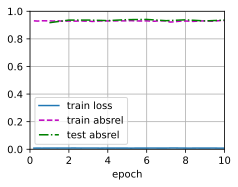

In [ ]:
# d2l.train_ch13(model, train_iter, test_iter, nn.MSELoss(), trainer, 10) #140
# epoch += 10
# torch.save(model.state_dict(), f'checkpoints/{epoch}.pth')


loss 0.008, train absrel 0.937, test absrel 0.946
14.6 examples/sec on [device(type='cuda', index=0)]


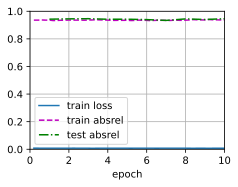

In [ ]:
# d2l.train_ch13(model, train_iter, test_iter, nn.MSELoss(), trainer, 10) #180
# epoch += 10
# torch.save(model.state_dict(), f'checkpoints/{epoch}.pth')


In [ ]:
import cv2
from matplotlib import pyplot as plt
model.to('cuda')
raw_img = cv2.imread('examples/2025_08_08_02_02_IMG_8783.png')
g_pred = model.infer_image(raw_img)


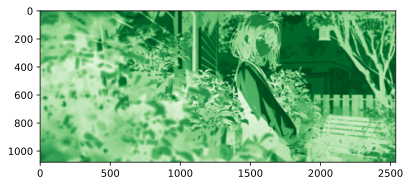

In [ ]:
plt.imshow(g_pred, cmap='Greens') # 预测的G通道

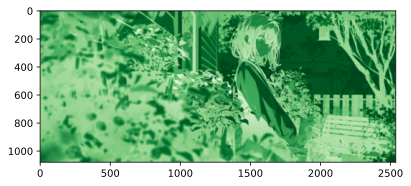

In [ ]:
plt.imshow(raw_img[:, :, 1], cmap='Greens') #原图

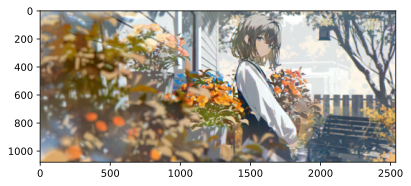

In [ ]:
from PIL import Image
pred_img = cv2.cvtColor(np.stack([raw_img[:, :, 0], g_pred, raw_img[:, :, 2]], axis=-1), cv2.COLOR_BGR2RGB)
plt.imshow(pred_img)
Image.fromarray(pred_img).save('synth.png') #预测的G通道与原图的RB通道合成

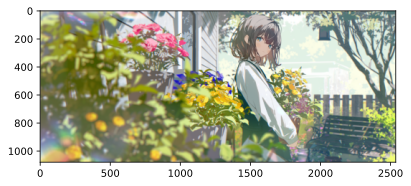

In [ ]:
plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)) #原图

In [6]:
import math
x = 0.946
absrel = 0.05 / (10 ** ((x - 1) * 10))
absrel, math.log10(0.05 / absrel) / 10 + 1

(0.17336842522626603, 0.946)

In [31]:
# absrel(y_pred, y)